# CircuitCruncher: Circuit Simulation Analysis Tools
 - This repository contains Python scripts and modules to perform various analyses on circuit simulation data. The main functionalities include:
    - Make Spice Save File: Generates a SPICE save file for specified variables.
    - Operating Point Extraction: Extracts and displays operating point parameters of transistors.
    - AC Analysis Data Extraction: Extracts bode plot and main AC data  
<div class="alert alert-block alert-info">
<b>Tip:</b>
For more information go to the Repo `https://github.com/abdelrahmanali15/CircuitCruncher`.
</div>

***


### Adding local library to path so it can be imported

In [1]:
import sys
sys.path.append('/home/tare/Repos/CircuitCruncher/lib')

In [2]:
import lib #import the local library

In [3]:
from lib import * #import the all functions from local library
import numpy as np
import pandas as pd
from prettytable import PrettyTable
import matplotlib.pyplot as plt

### Add all paths to your raw files for each analysis 

In [4]:
save_raw_path = '/home/tare/Repos/CircuitCruncher/tests/ota-5t_tb_without_data.raw'
op_raw_path = '/home/tare/Repos/CircuitCruncher/tests/ota-5t_tb_all_data.raw'
ac_raw_path = '/home/tare/Repos/CircuitCruncher/tests/ota-5t_tb2_ac.raw'
output_dir = '/home/tare/Repos/CircuitCruncher/tests/'

### Generate Save Spice file for Operating point
        1. In your xschem testbench run op analysis, make sure to add `.options savecurrents` before your control block 
        2. Netlist and Simulate
        3. A Raw file contains currents is saved (its path and name should have been defined above)
        4. Load the Raw file and covert it to single data frame.
        5. Use function `save_fet_vars` to parse the data frame and return Save spice file
        6. Include the save spice file in xschem inside your control block by `.include /path/to/save.spi`
        7. Rerun the simulation
        8. Now all transistors parameters specified are saved in the new raw file

In [5]:

Op_simNumber = 0 #choose the right number of your analysis, if you run op first then it will be 0 if you run it second then it's 1
(arrs, plots) = ng_raw_read(save_raw_path)


print(f"Simulation is {plots[Op_simNumber][b'plotname']}") # Print Simulation type to make sure it's what we want
if plots[Op_simNumber][b'plotname'] != b'Operating Point':
    raise(f"This Data Frame doesn't include Operating Point Analysis")



dfs = to_data_frames((arrs, plots))

df = dfs[0]  # Get the first DataFrame Assuming that it's the first analysis in the Raw File
# view_headers(df) # Print variables in dataframe to make sure that it's the one we need


saveVars = ['vgs','vds', 'vdsat', 'gm','gmbs', 'id', 'vth', 'gds','cgs'] # set variables to be saved in save.spi file
save_fet_vars(df.columns,saveVars,output_dir+'save.spi') # create save.spi file 




Simulation is b'Operating Point'
Output file created successfully


### Print OP Parameters for all transistors

In [6]:
Op_simNumber = 0
(arrs, plots) = ng_raw_read(op_raw_path)


print(plots[Op_simNumber][b'plotname']) # Print Simulation type to make sure it's what we want
if plots[Op_simNumber][b'plotname'] != b'Operating Point':
    raise(f"This Data Frame doesn't include Operating Point Analysis")



dfs = to_data_frames((arrs, plots))

df = dfs[0]  # Get the first DataFrame Assuming that it's the first analysis in the Raw File
# view_headers(df) # Print variables in dataframe to make sure that it's the one we need


# You can add variables other than default printed variables also add simple expresion of variables 
op_sim(df,html=True,additional_vars=['cgs','gmbs','vgs'],custom_expressions={"Avi":"gm*ro"},output_file=output_dir+'dc_op') # Extract Transistors OP Data

b'Operating Point'
+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------------+-----------+-----------+
| Parameter | @m.x1.xm1 | @m.x1.xm2 | @m.x1.xm3 | @m.x1.xm4 | @m.x1.xm5 | @m.x1.xm6 |  @m.x1.xm7  | @m.x1.xm8 | @m.x1.xm9 |
+-----------+-----------+-----------+-----------+-----------+-----------+-----------+-------------+-----------+-----------+
|    cgs    |   -9.75f  |   -9.75f  |  -34.85f  |  -34.85f  |   -9.49f  |   -9.55f  |   -19.36a   |  -569.12a |  -90.16a  |
|    gds    |   76.58n  |   76.59n  |   1.18μ   |   1.18μ   |   4.15μ   |  918.41n  |    0.16a    |  423.95f  |   16.07f  |
|     gm    |   34.00μ  |   34.00μ  |  103.29μ  |  103.29μ  |   82.09μ  |   90.99μ  |   222.81a   |   34.95p  |   1.40p   |
|    gmbs   |   8.31μ   |   8.31μ   |   20.09μ  |   20.09μ  |   18.74μ  |   20.74μ  |    77.14a   |   11.16p  |  424.18f  |
|     id    |   4.58μ   |   4.58μ   |   4.60μ   |   4.60μ   |   9.18μ   |   10.00μ  |    7.46a    |   1.29p   |  

### Extract AC Analysis Data 


                Summary of AC Analysis               
+-------+-------+---------+--------+--------+-------+
|   A0  | A0_db |    BW   |  UGF   |  GBW   |   PM  |
+-------+-------+---------+--------+--------+-------+
| 89.07 | 38.99 | 250.19k | 23.98M | 22.28M | 84.36 |
+-------+-------+---------+--------+--------+-------+

Table saved as /home/tare/Repos/CircuitCruncher/tests/ac_out.txt


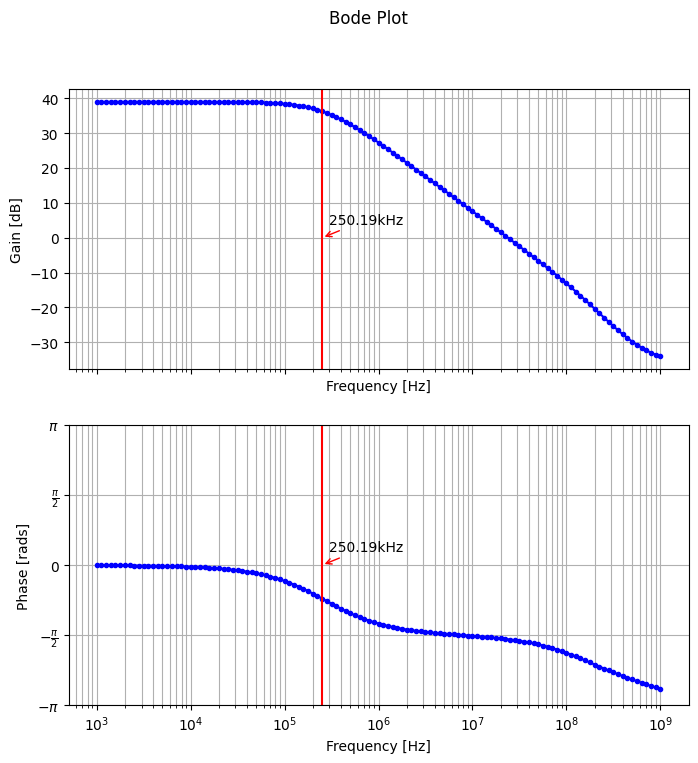

In [7]:

AC_simNumber = 0 # assuming that it is the first analysis if you run it after op in the same simulation the change 0 to 1
(arrs, plots) = ng_raw_read(ac_raw_path)

if plots[AC_simNumber][b'plotname'] != b'AC Analysis':
    raise Exception("This Data Frame doesn't include AC Analysis")

dfs = to_data_frames((arrs, plots))
df = dfs[0]

# view_headers(df)

ac_parameters = ac_analysis(df,save=True,output_file=output_dir+'ac_out')

plt.show()